Populating the interactive namespace from numpy and matplotlib


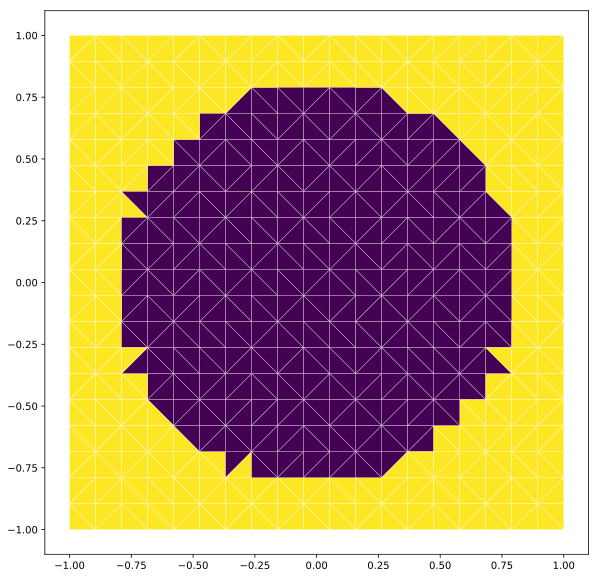

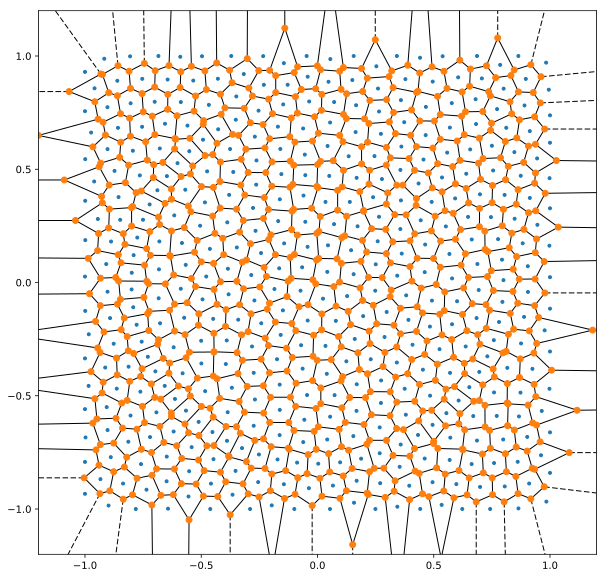

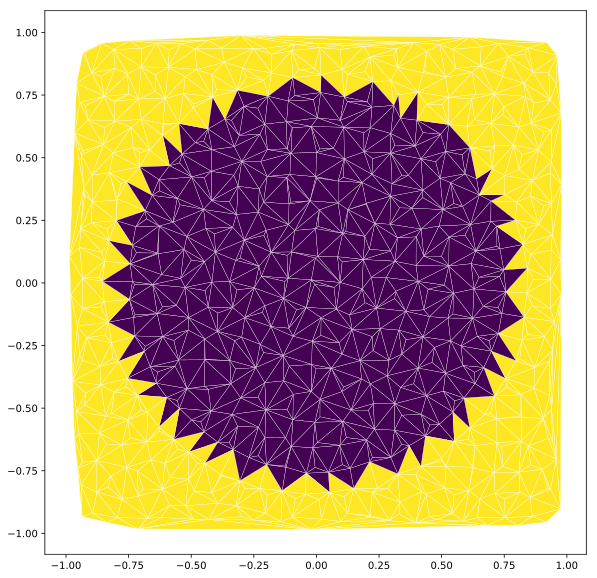

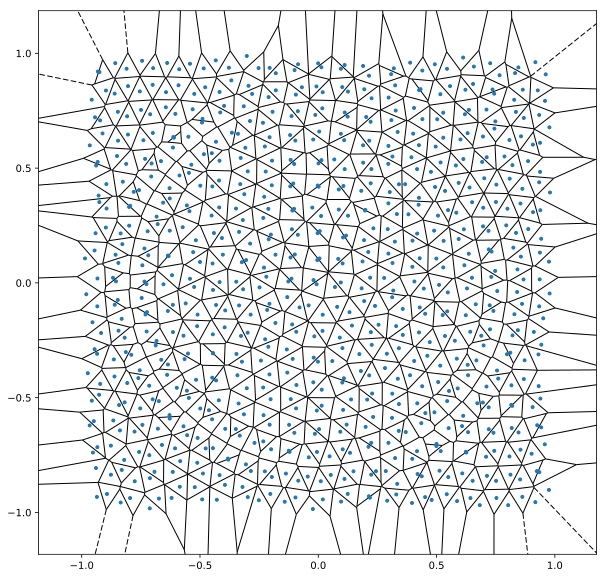

In [28]:
from numpy import linalg as LA
import numpy as np

import numpy.ma as ma

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.spatial import Voronoi, voronoi_plot_2d
import warnings

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'svg'
%pylab inline
pylab.rcParams['figure.figsize']=(10,10)

def regGrid():
    pts = []
    n = 19
    h = 2/n
    for i in range(n+1):
        for j in range(n+1):
            pts.append([-1 + i*h, -1 + j*h])
    return pts
#Circle
def u(v):
    return (v[0]**2 + v[1]**2)**0.5 - 0.8;

#dumbbell
#def u(v):
#    u1 = ((v[0] + 0.4)*(v[0] + 0.4) + v[1]*v[1])**0.5 - 0.9
#    u2 = ((v[0] - 0.4)*(v[0] - 0.4) + v[1]*v[1])**0.5 - 0.9
#    u3 = ((v[0] + 0.3)*(v[0] + 0.3) + v[1]*v[1])**0.5 - 0.25
#    u4 = ((v[0] - 0.3)*(v[0] - 0.3) + v[1]*v[1])**0.5 - 0.25
    #u5 = (v[0]**100 + v[1]**100)**0.01 - 1
#    return -min(-max(u1, u2), min(u3, u4));

def du(v):
    t = 0.01
    res = [0, 0]
    res[0] = (u([v[0] + t, v[1]]) - u([v[0] - t, v[1]]))/(2*t)
    res[1] = (u([v[0], v[1] + t]) - u([v[0], v[1] - t]))/(2*t)
    return res

def project(vert, vmask):
    e = 0.00000001
    t1 = 1
    v = vert
    uxy = np.array(du(v))
    if vmask == 2 or abs(v[0])> 1 or abs(v[1])> 1:
        if v[0] > 1:
            v[0] = 1
        if v[0] < -1:
            v[0] = -1
        if v[1] > 1:
            v[1] = 1
        if v[1] < -1:
            v[1] = -1
        return v
    else:
        i = 0
        while abs(u(v)) > e*LA.norm(uxy) and i<200:
            v = v - t1*u(v)/LA.norm(uxy)*uxy
            uxy = np.array(du(v))
            i+=1
        return v

def initMask(pts):
    vmask = np.sign([u(x) for x in pts])
    return vmask

def located(pt):
    if (u(pt) < 0.0001):
        return 1
    else:
        return 2

def findBorder(tri, pts):
    edgeIn = set()
    edgeOut = set()
    border = set()
    for x in range(len(tri)):
        if tri[x][0] < tri[x][1]:
            e1 = (tri[x][0], tri[x][1])
        else:
            e1 = (tri[x][1], tri[x][0])
        if tri[x][0] < tri[x][2]:
            e2 = (tri[x][0], tri[x][2])
        else:
            e2 = (tri[x][2], tri[x][0])
        if tri[x][2] < tri[x][1]:
            e3 = (tri[x][2], tri[x][1])
        else:
            e3 = (tri[x][1],tri[x][2])
        if trimask[x] == 1:
            edgeIn.add(e1)
            edgeIn.add(e2)
            edgeIn.add(e3)
        else:
            edgeOut.add(e1)
            edgeOut.add(e2)
            edgeOut.add(e3)

    border = edgeIn.intersection(edgeOut)
    L = 0
    for x in edgeIn:
        L += LA.norm(pts[x[0]]- pts[x[1]])**2
    inL0 = (L/len(edgeIn))**0.5
    L = 0
    for x in edgeOut:
        L += LA.norm(pts[x[0]]- pts[x[1]])**2
    outL0 = (L/len(edgeOut))**0.5
    return inL0,outL0, edgeIn, edgeOut, border

def formForces(edgeIn, edgeOut, pts, inL0, outL0):
    Mconst = 1.2
    edges = edgeIn.union(edgeOut)
    F1 = np.zeros(( len(pts), 2))
    for e in edges:
        p1 = e[0]
        p2 = e[1]
        L = LA.norm(pts[p1] - pts[p2])
        if L < 0.000001:
            L = 0.000001
        if vmask[p1] == -1:
            L0 = inL0
        else:
            L0 = outL0
        F1[p1] -= Mconst*(1.0 - L0 / L)*L0 / L*(pts[p1] - pts[p2])
        F1[p2] -= Mconst*(1.0 - L0 / L)*L0 / L*(pts[p2] - pts[p1])
    return F1

def moveMesh(pts, F1):
    t = 0.1
    toProj = set()
    for x in range(len(pts)):
        if t*LA.norm(F1[x]) > inL0/2:
            pts[x] = pts[x] + inL0/2*F1[x]/LA.norm(F1[x])
        else:
            pts[x] = pts[x] + t*F1[x]
        if (vmask[x] == 2 and (abs(pts[x][0]) > 1 or abs(pts[x][1]) > 1)) or vmask[x] == 0:
            toProj.add(x)
    return toProj

#регулярная сетка, Делоне
points = regGrid()
points = np.array(points)
vmask = initMask(points)

for i in range(50):
    tri = Delaunay(points)
            
    #удалить треугольники за пределами области

    index2point = lambda index: tri.points[index]
    all_centers = index2point(tri.vertices)
    insideBox = [(abs(item.mean(axis=0)[0]) < 0.999 and abs(item.mean(axis=0)[1]) < 0.999) for item in all_centers]
    faces=tri.simplices[np.where(insideBox)]

    #Маска треугольников
    all_centers = index2point(faces)
    trimask = np.array([located(item.mean(axis=0)) for item in all_centers])
    
    #Рисуем
    if i%50 == 0:
        plt.figure()
        plt.gca().set_aspect('equal')
        plt.tripcolor(points[:,0], points[:,1], faces, facecolors=trimask, edgecolors='w')
        fname = str(i) + 'circle.png'
        savefig(fname, bbox_inches='tight')
        plt.show()

    #Внешняя граница
    for x in tri.convex_hull:
        vmask[x[0]] = 2;
        vmask[x[1]] = 2;
    
    #Найдем границу и L0 внутри и снаружи
    inL0,outL0, edgeIn, edgeOut, border = findBorder(faces, points)
    for x in border:
        vmask[x[0]] = 0;
        vmask[x[1]] = 0;
            
    #считаем силы
    
    F1 = formForces(edgeIn, edgeOut, points, inL0, outL0)
            
    #двигаем силы и проецируем границу
    toProj = moveMesh(points, F1)
    for p in toProj:
        points[p] = project(points[p], vmask[p])
        
vor = Voronoi(points)
voronoi_plot_2d(vor)
plt.show()
vpts = set()
for region in vor.regions:
    if not -1 in region:
        for i in region:
            vpts.add((vor.vertices[i][0], vor.vertices[i][1]))
pts = []
for p in vpts:
    if abs(p[0])<=1 and abs(p[1])<=1:
        pts.append([p[0], p[1]])
pts = np.array(pts)

tri2 = Delaunay(pts)
faces = []
for face in tri2.vertices:
    if all(p in vpts for p in face):
        faces.append(face)

#Маска треугольников
index2point = lambda index: tri2.points[index]
all_centers = index2point(faces)
trimask = np.array([located(item.mean(axis=0)) for item in all_centers])
    
#Рисуем
plt.figure()
plt.gca().set_aspect('equal')
plt.tripcolor(pts[:,0], pts[:,1], faces, facecolors=trimask, edgecolors='w')
savefig("cl_tri2.png", bbox_inches='tight', dpi=400)
plt.show()

vor = Voronoi(pts)
voronoi_plot_2d(vor, show_vertices = 0)
#for i in range(len(vor.point_region)):
#    polygon = [vor.vertices[j] for j in vor.regions[vor.point_region[i]]]
#    if u(pts[i])<=0:
#        col = '#ffff80'
#    else:
#        col = '#99b3ff'
#    plt.fill(*zip(*polygon), color = col)
savefig("cl_vor2.png", bbox_inches='tight', dpi=400)
plt.show()
